In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

In [25]:
tf.data

<module 'tensorflow._api.v2.data' from '/Users/rakeshkumar/miniconda3/lib/python3.6/site-packages/tensorflow/_api/v2/data/__init__.py'>

We'll be working with *Life Expectancy* dataset from World Bank that captures the birth rate and life expectancy of 190 countries across the globe. We'll use this data to build linear regression model in tensorflow.

In [26]:
data = {}
with open("birth_life_2010.txt", "r") as file:
    for line in file.readlines()[1:]:
        temp = line.split("\t")
        data[temp[0]] = (float(temp[1]), float(temp[2][:-1]))
        
data = pd.DataFrame(data).transpose()
data.columns = ["birth_rate", "life_expectancy"]
data.head()

,birth_rate,life_expectancy
Vietnam,1.822,74.828244
Vanuatu,3.869,70.819488
Tonga,3.911,72.150659
Timor-Leste,5.578,61.999854
Thailand,1.579,73.927659


In [27]:
# Convert dataframe into features and targets nd-arrays
X_input = data["birth_rate"].values
target = data["life_expectancy"].values

# Shuffle the data
np.random.seed(123)
perms = np.random.permutation(X_input.shape[0])
X_input = X_input[perms]
target = target[perms]

X_input.shape, target.shape

((190,), (190,))

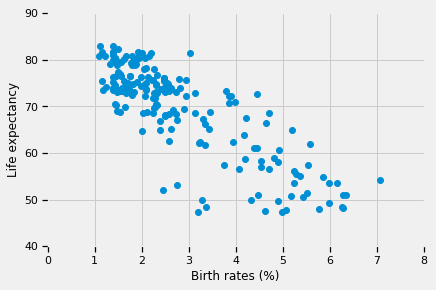

In [28]:
plt.scatter(X_input, target)
plt.xlim([0, 8])
plt.ylim([40, 90])
plt.xlabel("Birth rates (%)")
plt.ylabel("Life expectancy");

In [29]:
# Instatiate a graph object
g = tf.Graph()

# Define the computations within the graph
with g.as_default():
    # Define placeholders
    X = tf.placeholder(dtype=tf.float32, shape=(None), name="X")
    y = tf.placeholder(dtype=tf.float32, shape=(None), name="y")

    # Define parameters
    w = tf.get_variable("weight", initializer=tf.constant(0, tf.float32))
    b = tf.get_variable("bias", initializer=tf.constant(0, tf.float32))

    # Define predictions
    y_pred = w * X + b

    # Define loss
    loss = tf.reduce_mean(tf.square(y - y_pred))

    # Define optimizer
    optimizer = tf.train.GradientDescentOptimizer(
        learning_rate=0.09).minimize(loss)
    
    # Initialize all global variables
    init = tf.global_variables_initializer()

# Run the graph - Batch Gradient Descent
with tf.Session(graph=g) as sess:
    sess.run(init)
    costs = []
    
    for epoch in range(300):
        cost, _ = sess.run([loss, optimizer], feed_dict={X: X_input, y: target})
        costs.append(cost)
        
    w_out, b_out = sess.run([w, b])

# Plot the loss curve
plt.plot(range(300), costs)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Batch Gradient Descent");

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [13]:
w_out, b_out, w_out * 1.8220 + b_out

NameError: name 'w_out' is not defined

In [14]:
# Instatiate a graph object
g = tf.Graph()

# Define the computations within the graph
with g.as_default():
    # Define placeholders
    X = tf.placeholder(dtype=tf.float32, shape=(None), name="X")
    y = tf.placeholder(dtype=tf.float32, shape=(None), name="y")

    # Define parameters
    w = tf.get_variable("weight", initializer=tf.constant(0, tf.float32))
    b = tf.get_variable("bias", initializer=tf.constant(0, tf.float32))

    # Define predictions
    y_pred = w * X + b

    # Define loss
    loss = tf.square(y - y_pred)

    # Define optimizer
    optimizer = tf.train.RMSPropOptimizer(
        learning_rate=0.01).minimize(loss)
    
    # Initialize all global variables
    init = tf.global_variables_initializer()

# Run the graph - Stochastic Gradient Descent
with tf.Session(graph=g) as sess:
    sess.run(init)
    costs = []
    
    for epoch in range(200):
        cost_epoch = 0
        for x_, y_ in zip(X_input, target):
            cost, _ = sess.run([loss, optimizer], feed_dict={X: x_, y: y_})
            cost_epoch += cost
            
        costs.append(cost_epoch)
        
    w_out, b_out = sess.run([w, b])

# Plot the loss curve
plt.plot(range(200), costs)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Stochastic Gradient Descent");

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [15]:
w_out, b_out, w_out * 1.8220 + b_out

NameError: name 'w_out' is not defined

**Takeaway:** The lower the batch size, the more epochs we need to get the learning algorithm to converge to a very low loss. SGD is more expensive that BGD even though BGD has more epochs. Moreover, BGD converges to the parameters solved using normal equation method but SGD hasn't. Finally, we needed to use RmsProp to scale gradients while approaching the minimum that basically reduce learning rates as it gets closer to the minimum region to avoid divergence. Let's plot the fitted line:

NameError: name 'w_out' is not defined

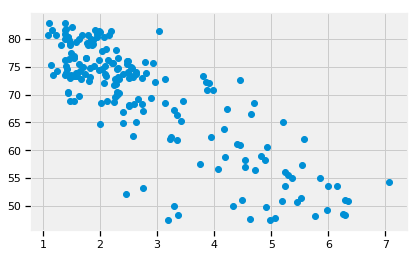

In [16]:
plt.scatter(X_input, target, label="Actual data")
plt.plot(X_input, w_out * X_input + b_out, 'r', label="Predicted data")
plt.xlim([0, 8])
plt.ylim([40, 90])
plt.xlabel("Birth rates (%)")
plt.ylabel("Life expectancy");

Looks like we have some outliers here:

In [17]:
%%R -i X_input,target
lin_model = lm(target ~ X_input)
plot(lin_model, which=4, cook.levels=(4/(190 - 2)))
print(summary(lin_model))

UsageError: Cell magic `%%R` not found.


In [18]:
%%R -i data
lin_model = lm(data$life_expectancy ~ ., data=data)
plot(lin_model, which=4, cook.levels=(4/(190 - 2)))
print(summary(lin_model))

UsageError: Cell magic `%%R` not found.


In [19]:
data.loc[["Niger", "South Africa", "Lesotho"]]

,birth_rate,life_expectancy
Niger,7.063,54.265634
South Africa,2.458,52.081488
Lesotho,3.199,47.365073


We'll run 4 different models:
1. model 1: use square error
2. model 2: use absolute error
3. model 3: use huber loss
4. model 4: use square loss but remove the 3 outliers

In [20]:
def huber_loss(predictions, target, delta=1):
    """Implements Huber Loss."""
    residuals = tf.abs(target - predictions)
    
    def f1():
        return 0.5 * tf.square(residuals)
    
    def f2():
        return delta * (residuals - 0.5 * delta)
    
    return tf.cond(residuals < delta, f1, f2)

In [21]:
# Instatiate a graph object
g = tf.Graph()

# Define the computations within the graph
with g.as_default():
    # Define placeholders
    X = tf.placeholder(dtype=tf.float32, shape=(None), name="X")
    y = tf.placeholder(dtype=tf.float32, shape=(None), name="y")

    # Define parameters
    w = tf.get_variable("weight", initializer=tf.constant(0, tf.float32))
    b = tf.get_variable("bias", initializer=tf.constant(0, tf.float32))

    # Define predictions
    y_pred = w * X + b

    # Define loss
    loss_sq = tf.square(y - y_pred)
    loss_abs = tf.abs(y - y_pred)
    loss_huber = huber_loss(y_pred, y, delta=14)

    # Define optimizer
    optimizer_sq = tf.train.RMSPropOptimizer(
        learning_rate=0.01).minimize(loss_sq)
    optimizer_abs = tf.train.RMSPropOptimizer(
        learning_rate=0.01).minimize(loss_abs)
    optimizer_huber = tf.train.RMSPropOptimizer(
        learning_rate=0.01).minimize(loss_huber)

    # Initialize all global variables
    init = tf.global_variables_initializer()

# Run the graph - Stochastic Gradient Descent
methods = {"sq": [loss_sq, optimizer_sq],
           "abs": [loss_abs, optimizer_abs],
           "huber": [loss_huber, optimizer_huber],
           "without_outliers": [loss_sq, optimizer_sq]}

costs = {"sq": [], "abs": [], "huber": [], "without_outliers": []}
params = {"sq": [], "abs": [], "huber": [], "without_outliers": []}

# Exclude the outliers
ouliers = [11, 43, 155]
mask = np.array([i in outliers for i in range(len(X_input))])
X_input_wo = X_input[~mask]
target_wo = target[~mask]

for method in methods.keys():
    with tf.Session(graph=g) as sess:
        sess.run(init)

        for epoch in range(200):
            cost_epoch = 0
            if method == "without_outliers":
                for x_, y_ in zip(X_input_wo, target_wo):
                    cost, _ = sess.run([methods[method][0], methods[method][1]],
                                       feed_dict={X: x_, y: y_})
                    cost_epoch += cost

                costs[method].append(cost_epoch)
            else:
                for x_, y_ in zip(X_input, target):
                    cost, _ = sess.run([methods[method][0], methods[method][1]],
                                       feed_dict={X: x_, y: y_})
                    cost_epoch += cost

                costs[method].append(cost_epoch)
        print(sess.run([w, b]))
        params[method].append(sess.run([w, b]))

# Get the parameters
w_out_sq, b_out_sq = params["sq"][0]
w_out_abs, b_out_abs = params["abs"][0]
w_out_huber, b_out_huber = params["huber"][0]
w_out_wo, b_out_wo = params["without_outliers"][0]

# Plot the fitted lines
plt.figure(figsize=(12, 8))
plt.scatter(X_input, target, label="Actual data")
plt.plot(X_input, w_out_sq * X_input + b_out_sq,
         '--r', label="Fitted line - square loss")
plt.plot(X_input, w_out_abs * X_input + b_out_abs,
         '--g', label="Fitted line - absolute loss")
plt.plot(X_input, w_out_huber * X_input + b_out_huber,
         '--b', label="Fitted line - huber loss")
plt.plot(X_input, w_out_wo * X_input + b_out_wo,
         '--y', label="Fitted line - without outliers")
plt.xlim([0, 8])
plt.ylim([40, 90])
plt.xlabel("Birth rates (%)")
plt.ylabel("Life expectancy (years)")
plt.title("Life expectancy vs. birth rate")
plt.legend();

AttributeError: module 'tensorflow' has no attribute 'placeholder'

As the graph above shows, there is no noticeable difference between the fitted lines of 4 different models. The reason is because the outliers were not influential and outliers mainly affects $R^2$ and residual standard error. The 3 examples here either have high leverage and low studentized residuals or low leverage and high studentized residuals. In order for an example (observation) to be influential, the studentized residual should be greater than 3 and the leverage be > (number of predictors + 1 / number of examples) or Cook's distance > (4 / number of examples).

In [22]:
outliers_countries = ["Niger", "South Africa", "Lesotho"]
mask_index = np.array([i in outliers_countries for i in data.index])
data_wo = data[~mask_index]

In [23]:
%%R -i data_wo
lin_model = lm(data_wo$life_expectancy ~ ., data=data_wo)
print(summary(lin_model))

UsageError: Cell magic `%%R` not found.
